In [2]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
import shap

In [4]:
# Load and prepare the datasets as before

# Set current directory and paths
current_directory = os.getcwd()
relative_path = '../data/combined_headlines_new.csv'
absolute_path = os.path.abspath(relative_path)

# Load the dataset into a DataFrame
df = pd.read_csv(absolute_path)
df.to_csv('../data/hemant_headlines_data.csv', index=False)
headlines_df = pd.read_csv('../data/hemant_headlines_data.csv')


In [5]:
# Preprocess the headlines dataset
headlines_df.columns = ['Date', 'Headlines']
headlines_df['Date'] = pd.to_datetime(headlines_df['Date'],errors='coerce')
headlines_df.sort_values(by='Date', inplace=True)
headlines_df = headlines_df.reset_index(drop=True)

min_date = headlines_df['Date'].min().date()
max_date = headlines_df['Date'].max().date() + pd.Timedelta(days=7)


In [6]:
# Load SPY historical data
sp500_df = yf.Ticker("SPY").history(start= min_date, end= max_date)
sp500_df.reset_index(inplace=True)
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], errors='coerce').dt.normalize()
sp500_df['Date'] = sp500_df['Date'].dt.tz_localize(None)


In [7]:
# Calculate market features
sp500_df['Variation'] = sp500_df['Close'].diff()
sp500_df['Volatility'] = sp500_df['High'] - sp500_df['Low']
sp500_df['Label'] = np.where(sp500_df['Variation'] > 0, 'Increase', np.where(sp500_df['Variation'] < 0, 'Decrease', 'No Change'))


In [8]:
# Merge datasets and filter
merged_df = pd.merge(headlines_df, sp500_df, on='Date', how='inner')
filtered_df = merged_df[merged_df['Label'] != 'No Change'].reset_index(drop=True)


In [9]:
# Load pre-trained DistilBERT model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [10]:
# Function to tokenize headlines
def tokenize_headlines(headlines):
    return tokenizer(headlines, padding=True, truncation=True, max_length=128, return_tensors='tf')

In [11]:
# Function to apply sentiment analysis on a segment
def sentiment_analysis_on_segment(segment):
    try:
        tokenized_data = tokenize_headlines(segment['Headlines'].tolist())
        outputs = model(tokenized_data['input_ids'], attention_mask=tokenized_data['attention_mask'])
        logits = outputs.logits
        probabilities = tf.nn.softmax(logits, axis=-1)
        sentiment_scores = probabilities[:, 1].numpy()  # Continuous score between 0 and 1
        segment['Sentiment_Score'] = sentiment_scores
    except Exception as e:
        print(f"Error processing segment: {e}")
        segment['Sentiment_Score'] = None
    
    return segment


In [12]:
# Process the dataset in chunks for sentiment analysis
chunk_size = 500
segments = [filtered_df[i:i + chunk_size] for i in range(0, filtered_df.shape[0], chunk_size)]
results = [sentiment_analysis_on_segment(segment) for segment in segments]
final_df = pd.concat(results, axis=0).reset_index(drop=True)
final_df.to_csv('Hemant_final_sentiment_analysis.csv', index=False)

In [13]:
# Convert label to score values
final_df['Label_Score'] = final_df['Label'].map({'Increase': 1, 'Decrease': 0})


In [14]:
# Add features
features = ['Sentiment_Score', 'Close', 'Volatility']
target = 'Label_Score'


In [15]:
# Time-Series Split
tscv = TimeSeriesSplit(n_splits=5)
X = final_df[features]
y = final_df[target]


In [16]:
# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)


In [17]:
# Train and evaluate using TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 4354, number of negative: 3496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 7850, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554650 -> initscore=0.219476
[LightGBM] [Info] Start training from score 0.219476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model training with GridSearch
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_predXgb = best_model.predict(X_test)

In [20]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_predXgb))
print("Classification Report:\n", classification_report(y_test, y_predXgb))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4173
           1       1.00      1.00      1.00      5247

    accuracy                           1.00      9420
   macro avg       1.00      1.00      1.00      9420
weighted avg       1.00      1.00      1.00      9420



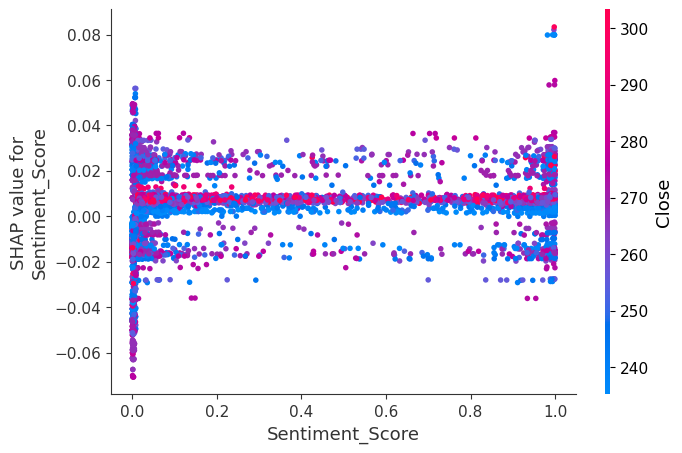

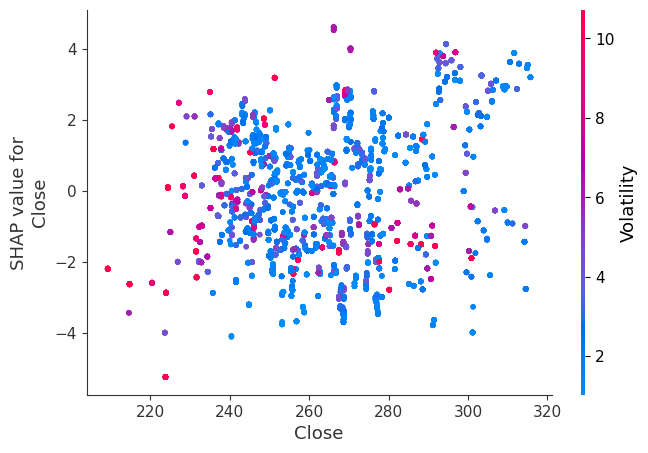

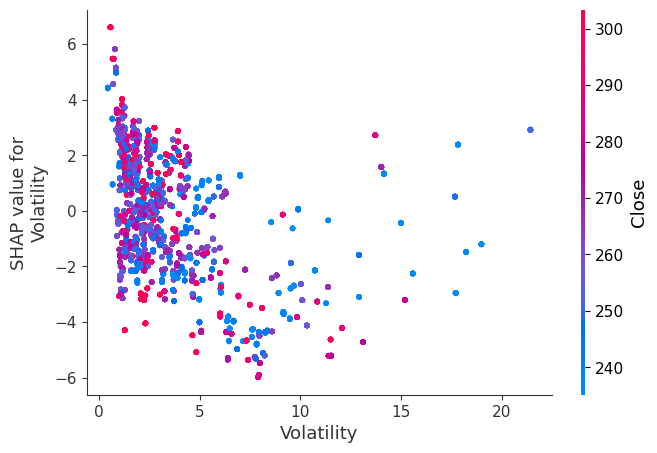

In [21]:
# SHAP analysis
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# List of feature names
features = X_test.columns

# Generate dependence plots for each feature
for feature in features:
    shap.dependence_plot(feature, shap_values, X_test, feature_names=features)





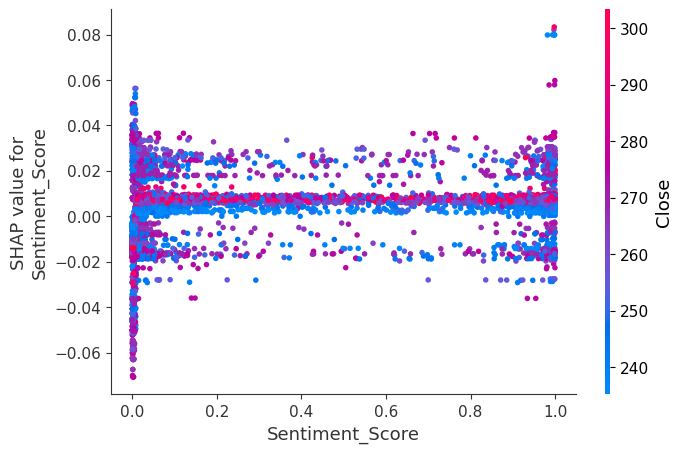

In [22]:
# Test with the first feature
shap.dependence_plot(features[0], shap_values, X_test, feature_names=features)

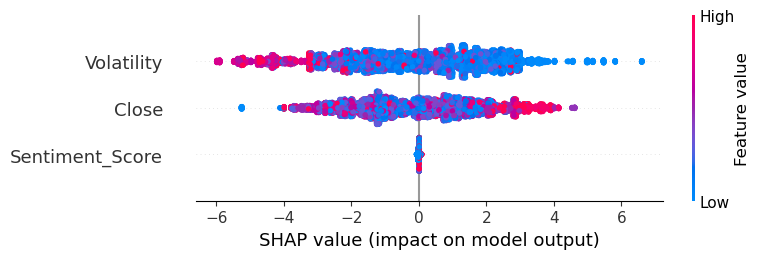

In [23]:
# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)




Shape of shap_values: (9420, 3)


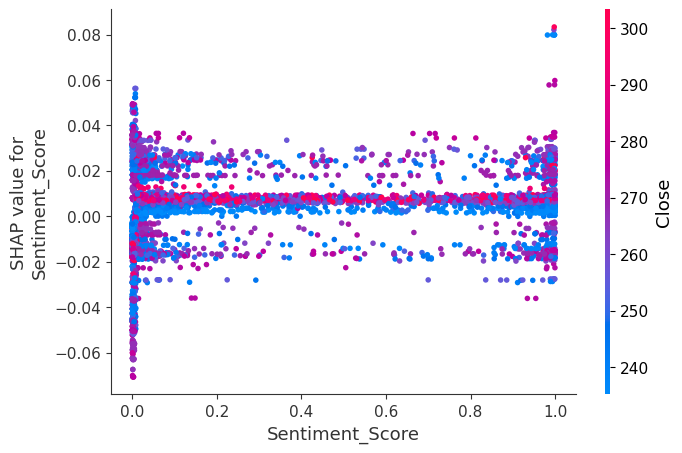

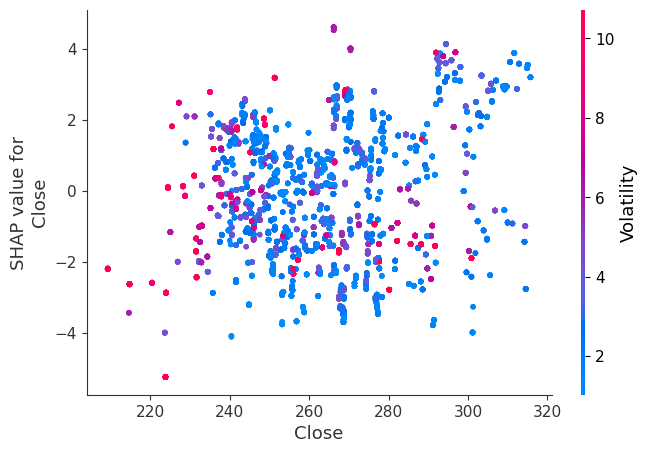

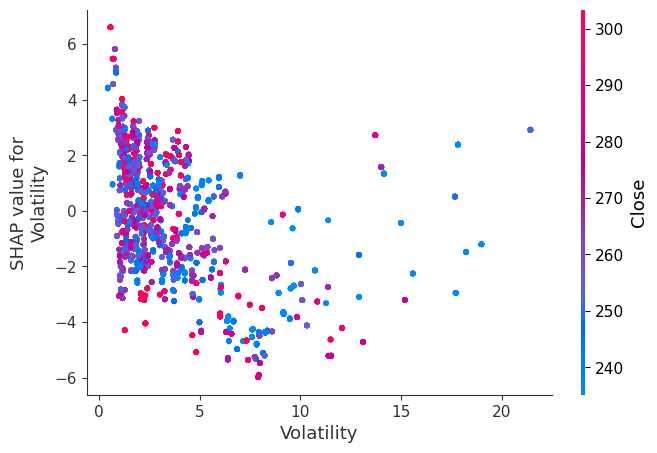

In [31]:
import shap

# Convert features to a list if it's a pandas Index
if hasattr(features, 'tolist'):
    features = features.tolist()

# Print shapes to debug
print(f"Shape of shap_values: {shap_values.shape}")

# Dependence plot for individual feature importance
for feature in features:
    try:
        feature_index = features.index(feature)  # Find the index of the feature
        shap.dependence_plot(feature_index, shap_values, X_test, feature_names=features)
    except IndexError as e:
        print(f"IndexError: {e}")
    except Exception as e:
        print(f"Error: {e}")


In [ ]:
pip install streamlit shap xgboost transformers